## <b> Лабораторна робота №2
"Метрики"\
Виконала: Челюскіна Юлія КМ-21 (2-га підгрупа)

---

### Початкові дані (1)

In [2]:
import pandas as pd
df  = pd.read_csv("KM-21-2.csv", delimiter=",")
df



,GT,Model_1_0,Model_2_1
0,1,0.014745,0.996526
1,0,0.999735,0.003289
2,0,0.999786,0.125449
3,0,0.999695,0.000858
4,1,0.022115,0.786606
...,...,...,...
4395,0,0.999753,0.125449
4396,0,0.999777,0.125449
4397,0,0.909023,0.159557
4398,0,0.999737,0.125999


### Збалансованість (2)


In [3]:
df.describe()

,GT,Model_1_0,Model_2_1
count,4400.000000,4400.000000,4400.000000
mean,0.500000,0.502790,0.487270
std,0.500057,0.487012,0.435648
min,0.000000,0.000000,0.000000
25%,0.000000,0.009073,0.054026
50%,0.500000,0.216863,0.613696
75%,1.000000,0.999784,0.990292
max,1.000000,0.999973,0.998421


In [4]:
#Визначити збалансованість набору даних. Вивести кількість об’єктів кожного класу
df["GT"].value_counts()

GT
1    2200
0    2200
Name: count, dtype: int64

### Метрики

* Матриця помилок

|                    | Predicted Positive (1) | Predicted Negative (0) |
|--------------------|----------------------|----------------------|
| **Actual Positive (1)** | TP                   | FP                   |
| **Actual Negative (0)** | FN                   | TN                   |


* Accuracy = ( TP+TN  ) / ( TP+TN+FP+FN ) \
*Limitations of Accuracy:* Imbalanced Datasets,  The cost of false positives and negatives

* Precision = TP / ( TP+FP )\
(скільки з названих позитивними є справді позитивними)\
зменшення хибних тривог (1 рід помилок)

* Recall = TP / TP + FN\
TPR (скільки з позитивних було названо як позитивні)\
зменшення пропуску цілі (2 рід помилок)

* F-Score = 2 × ( ( Precision * Recall ) / ( Precision + Recall ) ) \
Гармонічне середнє точності та повноти

In [147]:
import sklearn.metrics as m
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

def model_metrics(res, goal):
    

    thresholds = [round((0+x*0.1), 2) for x in range(10)] + [0.99]
    accuracy = []
    precision = []
    bal_accuracy = []
    recall = []
    f_score = []
    matthews = []
    J = []
    roc_auc = []
    rp_auc = []
    
    print("Thresholds: ", thresholds)   
    for i in thresholds:
        if goal == 0:
            real = [x==0 for x in df["GT"]]
            pred = ( res > i).astype(int)
        else:
            real = df["GT"]
            pred = ( res > i).astype(int)
        conf_matr = m.confusion_matrix(real, pred)
        TP = conf_matr[0][0]
        FP = conf_matr[0][1]
        TN = conf_matr[1][1]
        FN = conf_matr[1][0]
        accuracy.append(m.accuracy_score(real, pred))
        precision.append(m.precision_score(real, pred))
        bal_accuracy.append(m.balanced_accuracy_score(real, pred))
        recall.append(m.recall_score(real, pred))
        f_score.append(m.f1_score(real, pred))
        matthews.append(m.matthews_corrcoef(real, pred))
        conf_matr = m.confusion_matrix(real, pred)
        J.append(TP/(TP+FN) + TN/(TN+FP) - 1)
        roc_auc.append(m.roc_auc_score(real, pred))
        p, r, _ = m.precision_recall_curve(real, pred)
        rp_auc.append(m.auc(r, p))
    # Словник метрик
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Balanced Accuracy': bal_accuracy,
        'Recall': recall,
        'F-score': f_score,
        "Matthews' Corr Coeff": matthews,
        'J-Index': J,
        'ROC AUC': roc_auc,
        'PR AUC': rp_auc
    }

    print(f"Accuracy: {[round(a, 3) for a in accuracy]}")
    print(f"Precision: {[round(p, 3) for p in precision]}")
    print(f"Balanced Accuracy: {[round(b, 3) for b in bal_accuracy]}")
    print(f"Recall: {[round(r, 3) for r in recall]}")
    print(f"F-Score: {[round(f, 3) for f in f_score]}")
    print(f"Matthews Corr Coef: {[round(m, 3) for m in matthews]}")
    print(f"Youden's J Statistic: {[round(j, 3) for j in J]}")
    print(f"ROC AUC: {[round(r, 3) for r in roc_auc]}")
    print(f"Precision-Recall AUC: {[round(rp, 3) for rp in rp_auc]}")
    

    plt.figure(figsize=(10, 6))

    # Кольори для кожної метрики
    colors = plt.cm.tab10(np.linspace(0, 1, len(metrics)))

    for (label, values), color in zip(metrics.items(), colors):
        plt.plot(thresholds, values, label=label, color=color)
    
        # Позначення максимуму
        max_idx = np.argmax(values)
        plt.scatter(thresholds[max_idx], values[max_idx], color=color, edgecolors='black', s=100)

    plt.xlabel("Threshold")
    plt.ylabel("Metric Value")
    plt.title("Metrics vs Thresholds")
    plt.legend(loc='best', fontsize=8)
    plt.grid(True)
    plt.show()

        
    # Побудова горизонтального розсіювання з шумом по вертикалі
    plt.figure(figsize=(10, 3))
    y_jitter = np.random.uniform(-0.1, 0.1, size=len(res))  # Додаємо шум по вертикалі
    plt.scatter(res, y_jitter, c=real, cmap="bwr", edgecolors="k")

    for (label, metric), color in zip(metrics.items(), colors):
        plt.axvline(x=thresholds[metric.index(max(metric))], color=color, linestyle='--', label=label)

    plt.xlabel("Classifier Score")
    plt.yticks([])  # Прибираємо мітки по осі Y
    plt.title("Модель для "+ str(goal))
    # Для того, щоб всі лінії одного кольору відображались як одна в легенді
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    plt.show()

    # Pr-крива

    


    prs, recs, thrs = m.precision_recall_curve(real,res)
        # Знаходження точки, де recs ≈ prs
    diff = np.abs(recs - prs)
    idx = np.argmin(diff)  # Індекс найближчої точки
    intersection_point = (recs[idx], prs[idx])
    threshold_at_intersection = thrs[idx] if idx < len(thrs) else None  # Перевірка довжини

    
    plt.figure(figsize=(10, 6))
    plt.grid(True)
    plt.plot(recs, prs, label = f'(AUC = {m.auc(recs, prs):.4f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Діагональ випадкового класифікатора
    plt.ylim([0,1.1]); plt.xlim([0,1.1])
    plt.scatter(*intersection_point, color='red', zorder=3, label=f'Поріг={threshold_at_intersection:.4f}')
    plt.legend()
    

    # ROC-крива
    plt.figure(figsize=(10, 6))
    # Додавання точки Йодена
    
    fpr, tpr, thrs = m.roc_curve(real, res)
    # Знаходження індексу Йодена
    j_scores = tpr - fpr
    idx_j = np.argmax(j_scores)  # Індекс максимальної різниці TPR - FPR
    j_point = (fpr[idx_j], tpr[idx_j])
    threshold_j = thrs[idx_j]
    
    plt.plot(fpr, tpr, label=f'(AUC = {m.auc(fpr, tpr):.4f})')
    plt.scatter(*j_point, color='red', zorder=3, label=f'Поріг={threshold_j:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Діагональ випадкового класифікатора
    plt.ylim([0,1.1]); plt.xlim([0,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-крива')
    plt.grid(True)
    plt.legend()

    plt.show()
            

Thresholds:  [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
Accuracy: [0.5, 0.976, 0.986, 0.99, 0.99, 0.99, 0.989, 0.989, 0.986, 0.983, 0.967]
Precision: [0.5, 0.962, 0.984, 0.994, 0.995, 0.995, 0.996, 0.996, 0.996, 0.998, 0.999]
Balanced Accuracy: [0.5, 0.976, 0.986, 0.99, 0.99, 0.99, 0.989, 0.989, 0.986, 0.983, 0.967]
Recall: [1.0, 0.99, 0.989, 0.987, 0.986, 0.984, 0.983, 0.981, 0.975, 0.968, 0.935]
F-Score: [0.667, 0.976, 0.986, 0.99, 0.99, 0.99, 0.989, 0.989, 0.986, 0.983, 0.966]
Matthews Corr Coef: [0.015, 0.952, 0.973, 0.98, 0.981, 0.98, 0.979, 0.977, 0.972, 0.966, 0.936]
Youden's J Statistic: [0.5, 0.953, 0.973, 0.981, 0.981, 0.98, 0.979, 0.978, 0.972, 0.967, 0.938]
ROC AUC: [0.5, 0.976, 0.986, 0.99, 0.99, 0.99, 0.989, 0.989, 0.986, 0.983, 0.967]
Precision-Recall AUC: [0.75, 0.979, 0.989, 0.994, 0.994, 0.994, 0.994, 0.993, 0.992, 0.991, 0.983]


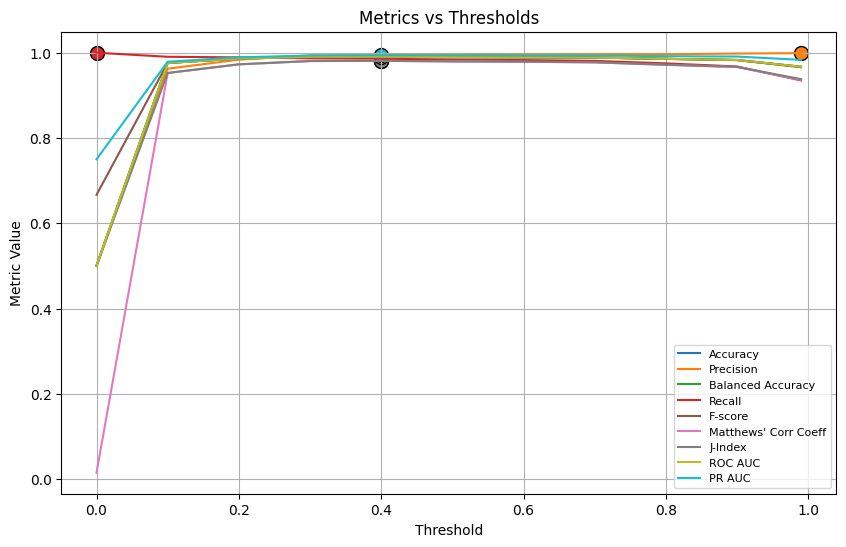

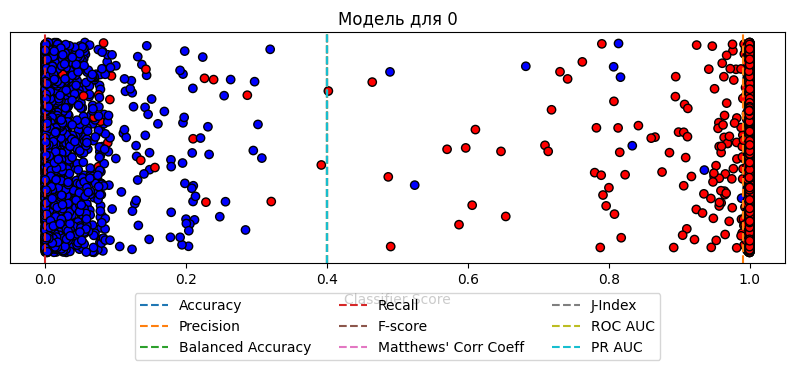

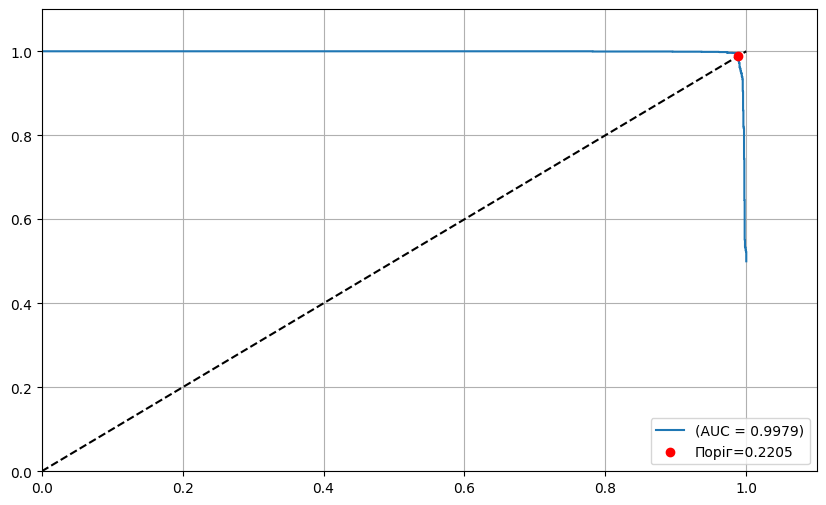

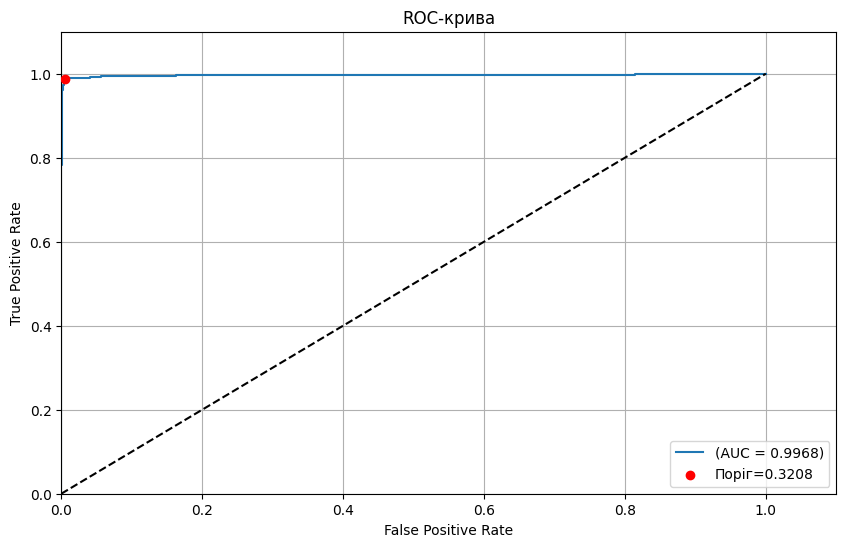

In [148]:
model_metrics(df["Model_1_0"], 0)


Thresholds:  [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
Accuracy: [0.54, 0.812, 0.991, 0.991, 0.991, 0.991, 0.992, 0.983, 0.824, 0.824, 0.764]
Precision: [0.521, 0.728, 0.987, 0.987, 0.987, 0.988, 0.99, 0.99, 0.997, 0.997, 0.997]
Balanced Accuracy: [0.54, 0.812, 0.991, 0.991, 0.991, 0.991, 0.992, 0.983, 0.824, 0.824, 0.764]
Recall: [1.0, 0.998, 0.995, 0.995, 0.995, 0.995, 0.995, 0.975, 0.651, 0.651, 0.53]
F-Score: [0.685, 0.842, 0.991, 0.991, 0.991, 0.991, 0.992, 0.983, 0.787, 0.787, 0.692]
Matthews Corr Coef: [0.205, 0.673, 0.982, 0.982, 0.982, 0.983, 0.984, 0.966, 0.692, 0.692, 0.598]
Youden's J Statistic: [0.521, 0.724, 0.982, 0.982, 0.982, 0.983, 0.984, 0.966, 0.737, 0.737, 0.677]
ROC AUC: [0.54, 0.812, 0.991, 0.991, 0.991, 0.991, 0.992, 0.983, 0.824, 0.824, 0.764]
Precision-Recall AUC: [0.76, 0.863, 0.992, 0.992, 0.992, 0.993, 0.993, 0.989, 0.911, 0.911, 0.881]


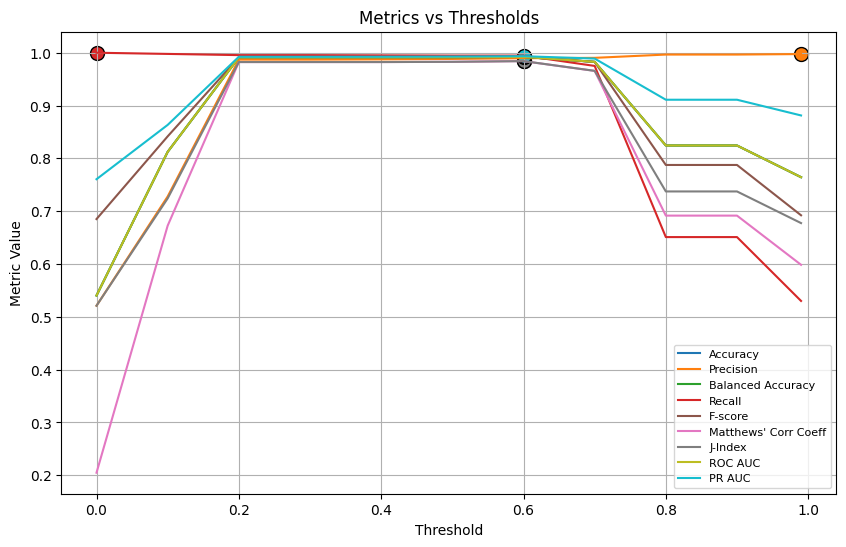

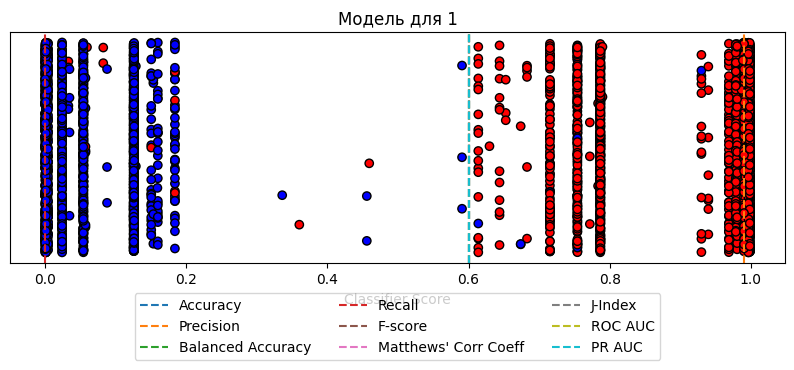

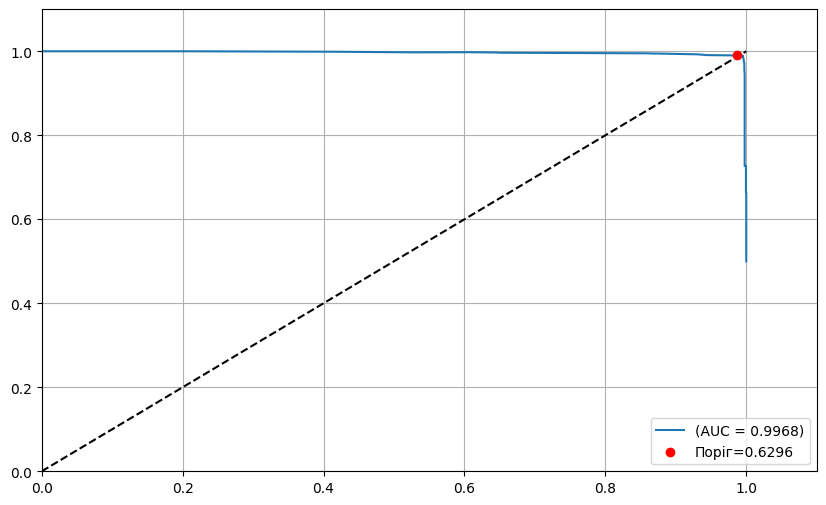

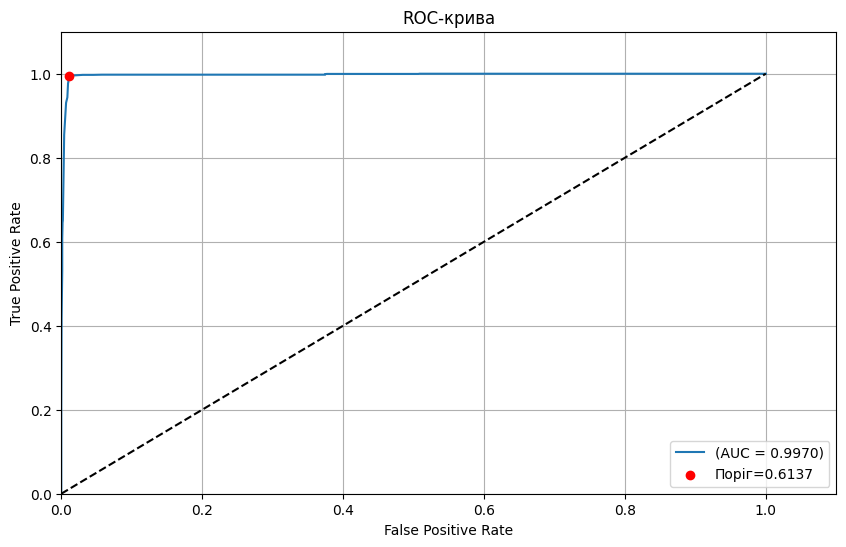

In [149]:
model_metrics(df["Model_2_1"], 1)

Використані джерела:
* https://www.geeksforgeeks.org/sklearn-classification-metrics/
* https://www.kaggle.com/code/pythonafroz/evaluation-metrics-used-in-machine-learning
* https://www.kaggle.com/code/nicholasgah/optimal-probability-thresholds-using-pr-curve